# Design of biosensors


Data were obtained from pubchem 

(https://pubchem.ncbi.nlm.nih.gov/compound/3345#section=Top)

In [1]:
%%capture
!pip install ipywidgets
!pip install py3Dmol

In [2]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
#tca_smiles = "C1=CC=C(C=C1)/C=C/C(=O)O"
fen = "CCC(=O)N(C1CC[NH+](CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"

# SMILES from pubchem except CVX build from RVX
ligands = {'FEN' : fen }

In [4]:
import shutil,subprocess,os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms as rdmt
import numpy as np
# from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Geometry import rdGeometry as geom
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed
from ipywidgets import interact, widgets
from IPython.display import display

In [5]:
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [6]:
def generate_molecule(name,smiles):
    """
    Generate the 3D molecular structure based on input SMILES
    ----------
    name : name of molecule
    smiles: SMILES of molecule
    Returns
    ----------
    Mol 
    
    """
    LIGAND_NAME = name
    m = Chem.MolFromSmiles(smiles)
    m_h = Chem.AddHs(m)
    # Embeed the geometry
    AllChem.EmbedMolecule(m_h, AllChem.ETKDG())
    # Setting name of molecule
    m_h.SetProp("_Name",LIGAND_NAME)
    return m_h

In [7]:
def get_conformers(mol,nr=500,rmsthreshold=0.1):
    """
    Generate 3D conformers of molecule using CSD-method
    ----------
    mol : RKdit molecule
    nr : integer, number of conformers to be generate
    rmsthreshold : float, prune conformers that are less rms away from another conf
    Returns
    ----------
    List of new conformation IDs
    """
    # Generate conformers on the CSD-method
    return AllChem.EmbedMultipleConfs(mol, numConfs=nr,useBasicKnowledge=True,\
                                      pruneRmsThresh=rmsthreshold,useExpTorsionAnglePrefs=True)

In [8]:
mols = {}
for name in ligands.keys():
    mols[name] = generate_molecule(name,ligands[name])

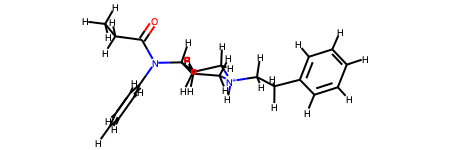

In [9]:
mols["FEN"]

In [10]:
for i in ligands.keys():
    cids = get_conformers(mols[i], 50,0.1)
    # Do a short minimization and compute the RMSD
    for cid in cids:
        _ = AllChem.MMFFOptimizeMolecule(mols[i], confId=cid)
    rmslist = []
    AllChem.AlignMolConformers(mols[i], RMSlist=rmslist)

In [11]:
molecule_widget = widgets.Dropdown(
    options=list(mols.keys()),
    value=list(mols.keys())[0],
    description='Molecule:',
    disabled=False,
)

In [12]:
molconf_widget = widgets.Label(
    value = 'Number of conformers: '+str(mols[molecule_widget.value].GetNumConformers())
)

In [13]:
def select_molecule(molecule):
    new_i = widgets.interactive(print_city, country=countryW, city=geoWs[country['new']])
    i.children = new_i.children
    
def on_change(change):
    from IPython.display import clear_output
    clear_output()
    molconf_widget.value = 'Number of conformers: '+str(mols[change['new']].GetNumConformers())
    display(container)
    interact(drawit,m=fixed(mols[change['new']]),p=fixed(p),confId=(0,mols[change['new']].GetNumConformers()-1));

In [14]:
container = widgets.HBox([molecule_widget, molconf_widget])
display(container)
# now construct the view and interactive widget:
p = py3Dmol.view(width=600,height=400)
# this is the widget that needs to tricker events
molecule_widget.observe(on_change, names='value')
interact(drawit,m=fixed(mols[molecule_widget.value]),p=fixed(p),confId=(0,mols[molecule_widget.value].GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=49), Output()), _dom_classes=('widget-inter…

In [15]:
def generate_rosetta_input(mol,name,charge=0):
    try:
        os.mkdir(name)
    except:
        print("Directory already there!")
    os.chdir(name)
    w = Chem.SDWriter(name+'.sdf')
    for i in mol.GetConformers():
        w.write(mol,confId=i.GetId())
    w.close()
    parm_exe="python2.7 /Users/pgreisen/Programs/Rosetta/Rosetta/main/source/scripts/python/public/molfile_to_params.py "
    exe=parm_exe+" "+name+".sdf -n "+name+" --conformers-in-one-file --recharge="+str(charge)+" -c "
    subprocess.Popen(exe,shell=True)
    print(exe)
    os.chdir('../')

In [16]:
pth=os.getcwd()

In [17]:
os.chdir(pth)
for key in mols:
    generate_rosetta_input(mols[key],key,Chem.GetFormalCharge(mols[key]) )

Directory already there!
python2.7 /Users/pgreisen/Programs/Rosetta/Rosetta/main/source/scripts/python/public/molfile_to_params.py  FEN.sdf -n FEN --conformers-in-one-file --recharge=1 -c 
